<a href="https://colab.research.google.com/github/joeldmott/inventory_project/blob/main/inventory_restocking_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing packages to read in data from Kaggle host site
import json
import os
from pathlib import Path
from google.colab import userdata

# api key for importing Kaggle and downloading the datasets
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

# api key for the json object below
api_key = userdata.get('API_KEY')

# using pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opening file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [2]:
import kaggle
#! kaggle datasets download joelmott/liquor-inventory-dataset
! kaggle datasets download residentmario/iowa-liquor-sales

Dataset URL: https://www.kaggle.com/datasets/residentmario/iowa-liquor-sales
License(s): CC0-1.0
iowa-liquor-sales.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip iowa-liquor-sales.zip

Archive:  iowa-liquor-sales.zip
replace Iowa_Liquor_Sales.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
import pandas as pd
df = pd.read_csv('/content/Iowa_Liquor_Sales.csv')
df.head()

<ipython-input-4-ee4148f6d4fc>:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/Iowa_Liquor_Sales.csv')


,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,...,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,S29198800001,11/20/2015,2191,Keokuk Spirits,1013 MAIN,KEOKUK,52632,"1013 MAIN\nKEOKUK 52632\n(40.39978, -91.387531)",56.0,Lee,...,297,Templeton Rye w/Flask,6,750,$18.09,$27.14,6,$162.84,4.50,1.19
1,S29195400002,11/21/2015,2205,Ding's Honk And Holler,900 E WASHINGTON,CLARINDA,51632,"900 E WASHINGTON\nCLARINDA 51632\n(40.739238, ...",73.0,Page,...,297,Templeton Rye w/Flask,6,750,$18.09,$27.14,12,$325.68,9.00,2.38
2,S29050300001,11/16/2015,3549,Quicker Liquor Store,1414 48TH ST,FORT MADISON,52627,"1414 48TH ST\nFORT MADISON 52627\n(40.624226, ...",56.0,Lee,...,249,Disaronno Amaretto Cavalli Mignon 3-50ml Pack,20,150,$6.40,$9.60,2,$19.20,0.30,0.08
3,S28867700001,11/04/2015,2513,Hy-Vee Food Store #2 / Iowa City,812 S 1ST AVE,IOWA CITY,52240,812 S 1ST AVE\nIOWA CITY 52240\n,52.0,Johnson,...,237,Knob Creek w/ Crystal Decanter,3,1750,$35.55,$53.34,3,$160.02,5.25,1.39
4,S29050800001,11/17/2015,3942,Twin Town Liquor,104 HIGHWAY 30 WEST,TOLEDO,52342,"104 HIGHWAY 30 WEST\nTOLEDO 52342\n(41.985887,...",86.0,Tama,...,249,Disaronno Amaretto Cavalli Mignon 3-50ml Pack,20,150,$6.40,$9.60,2,$19.20,0.30,0.08


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12591077 entries, 0 to 12591076
Data columns (total 24 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Invoice/Item Number    object        
 1   Date                   datetime64[ns]
 2   Store Number           int64         
 3   Store Name             object        
 4   Address                object        
 5   City                   object        
 6   Zip Code               object        
 7   Store Location         object        
 8   County Number          float64       
 9   County                 object        
 10  Category               float64       
 11  Category Name          object        
 12  Vendor Number          float64       
 13  Vendor Name            object        
 14  Item Number            int64         
 15  Item Description       object        
 16  Pack                   int64         
 17  Bottle Volume (ml)     int64         
 18  State Bottle Cost   

In [6]:
#Where are these stores?
#df.sample(50)
#Ah, they're all in (and from all around) Iowa.

In [7]:
#What's the date range?
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].min(), df['Date'].max()

(Timestamp('2012-01-03 00:00:00'), Timestamp('2017-10-31 00:00:00'))

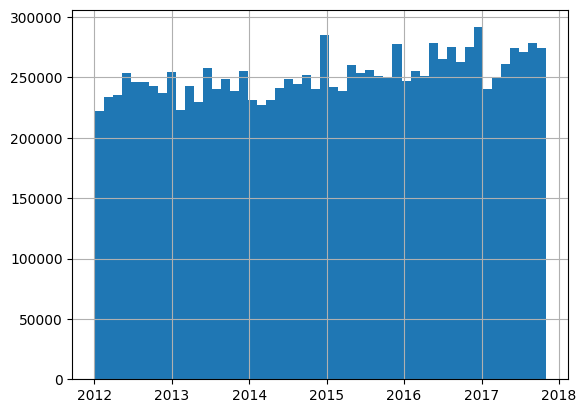

In [8]:
df['Date'].hist(bins=50);

Obviously, we'll drop the random few date entries from 2016-2018, but the real tragedy here is the missing data from the very end of 2015. I don't think it's a good idea to try and impute and time-series data here, so we'll have to drop everything after January 3rd, 2015. However, this still gives us three complete years of data, which isn't bad.

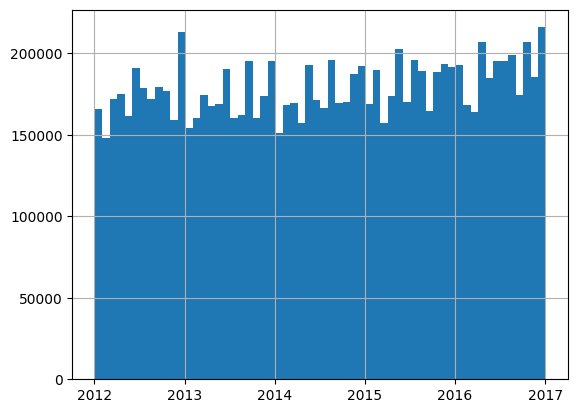

In [9]:
trimmed_df = df[~(df['Date'] > '2017-01-03 00:00:00')]
trimmed_df['Date'].hist(bins=60);

With our time-series data sorted out, let's examine the amount of stores we have.

In [10]:
#How many stores?
unique_stores = trimmed_df['Store Number'].unique()
len(unique_stores)

1752

In [11]:
#How many with more than 100 orders in here?
store_value_counts = trimmed_df['Store Number'].value_counts()
hundred_order_stores = pd.DataFrame(store_value_counts)
hundred_order_stores = hundred_order_stores[hundred_order_stores['count'] >= 100]
len(hundred_order_stores)

1679

In [12]:
#How many with more than 1000 orders in here?
store_value_counts = trimmed_df['Store Number'].value_counts()
thousand_order_stores = pd.DataFrame(store_value_counts)
thousand_order_stores = thousand_order_stores[thousand_order_stores['count'] >= 1000]
len(thousand_order_stores)

1267

That's a good amount of stores with a decent amount of rows to examine. We may wind up looking at the top ten or top 100 stores only depending on how the project goes.

Let's also look at vendors; while stores represent a variable that we may use to *subdivide* the dataset, vendors will remain an independent variable. As a categorical variable, they may balloon out to an overwhelming number of one-hot encoded variables, so we'll alomost certainly need to find a way to limit these.

In [13]:
#How many vendors total?
len(trimmed_df['Vendor Name'].unique())

331

In [14]:
#How many with more than 100 orders in here?
vendor_value_counts = trimmed_df['Vendor Name'].value_counts()
hundred_order_vendors = pd.DataFrame(vendor_value_counts)
hundred_order_vendors = hundred_order_vendors[hundred_order_vendors['count'] >= 100]
len(hundred_order_vendors)

168

In [15]:
#How many with more than 1000 orders in here?
thousand_order_vendors = pd.DataFrame(vendor_value_counts)
thousand_order_vendors = thousand_order_vendors[thousand_order_vendors['count'] >= 1000]
len(thousand_order_vendors)

93

93 vendors combined with the liqour categories and a few more continuous columns is probably still going to be too many to model without a problematic amount of noise and/or sparsity in our data. We may consider adding a limitation here to each store along the way. In other words, when we run a model on an individual store, we'll only include vendors that serviced that store with >= 1,000 orders.

This is especially important when we consider that this dataset covers an entire *state* with urban, suburban, and rural stores that all move different volumes of inventory; the vendors used will almost certainly vary from one store to the next.

Before we start examining stores in more detail, we need to take care of a few other things in our broader DataFrame. Specifically, we need to drop unnecessary columns and contend with what appear to be a few NaNs.

Let's first examine columns so we can see which to drop. I appreciate how the data has store, location, and item names and numbers, but for our purposes, we can drop a number of these redundancies.

Ultiamtely, if our goal is to predict when and how much to reorder, we can eliminate everything except date, store number, category, and bottles sold, but for now we'll still keep sales info since it's easy to include as a continuous column and we'll keep vendor names in case we want to come back and do more extensive modeling later.

In [16]:
columns_to_drop = ['Invoice/Item Number', 'Store Name', 'Address', 'City', 'Zip Code',
                   'Store Location', 'County Number', 'County', 'Category',
                   'Vendor Number', 'Item Number', 'Item Description', 'Bottle Volume (ml)',
                   'State Bottle Cost', 'State Bottle Retail', 'Pack', 'Volume Sold (Liters)',
                   'Volume Sold (Gallons)']
trimmed_df = trimmed_df.drop(columns_to_drop, axis=1)
trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10716678 entries, 0 to 10727535
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Date            datetime64[ns]
 1   Store Number    int64         
 2   Category Name   object        
 3   Vendor Name     object        
 4   Bottles Sold    int64         
 5   Sale (Dollars)  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 572.3+ MB


This may seem like just a few columns for now, but once we add the categorical columns in, this will quickly expand. Let's handle the NaN's now.

In [17]:
nan_rows = trimmed_df[trimmed_df.isna().any(axis=1)]
len(nan_rows)

10268

In [18]:
len(nan_rows) / len(trimmed_df)

0.0009581327347896429

NaN's only make up 0.04% of our data, so we can afford to drop them without sarcificing much data.

In [19]:
trimmed_df.dropna(axis=0, inplace=True)
trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10706410 entries, 6 to 10727535
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Date            datetime64[ns]
 1   Store Number    int64         
 2   Category Name   object        
 3   Vendor Name     object        
 4   Bottles Sold    int64         
 5   Sale (Dollars)  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 571.8+ MB


Now we can examine the categorical columns more carefully. We'll use the 'Store Number' column later on in order to subdivide the trimmed_df into stores, so let's begin with the 'Category Name' column.

In [20]:
len(trimmed_df['Category Name'].value_counts())

128

In [21]:
print(trimmed_df['Category Name'].value_counts().to_string())

Category Name
VODKA 80 PROOF                          1265967
CANADIAN WHISKIES                        936212
STRAIGHT BOURBON WHISKIES                543684
SPICED RUM                               530323
VODKA FLAVORED                           502813
BLENDED WHISKIES                         441610
TEQUILA                                  435298
IMPORTED VODKA                           404048
PUERTO RICO & VIRGIN ISLANDS RUM         395376
WHISKEY LIQUEUR                          334572
AMERICAN COCKTAILS                       284695
FLAVORED RUM                             278367
AMERICAN DRY GINS                        256386
IMPORTED VODKA - MISC                    256238
MISC. IMPORTED CORDIALS & LIQUEURS       246088
TENNESSEE WHISKIES                       245162
AMERICAN GRAPE BRANDIES                  243144
CREAM LIQUEURS                           232844
SCOTCH WHISKIES                          199770
IMPORTED SCHNAPPS                        169243
IMPORTED GRAPE BRANDIES   

That's too many to include all of them. Instead, we'll carefully consolidate these into more generalized categories. On one hand, we need to narrow these down for clarity and modeling purposes. On the other hand, we don't want to eliminate too many categories, especially those with a larger value count.

For example, instead of just consolidating everything containing the string 'VODKA' to a general 'VODKA' category, we can at least distinguish between 'VODKA' and a new category called 'FLAVORED VODKA'. We can also do something like divide the whiskey categories into three new ones: 'BOURBON', 'SCOTCH', and 'OTHER WHISKEY'.

In [22]:
#I can use the str.contains method for some categories that are easier
# to generalize. Let's do those first:
trimmed_df.loc[trimmed_df['Category Name'].str.contains('BOURBON'), 'Category Name'] = 'BOURBON'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Bourbon'), 'Category Name'] = 'BOURBON'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('RYE'), 'Category Name'] = 'BLENDED AND OTHER WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Rye'), 'Category Name'] = 'BLENDED AND OTHER WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Tequila'), 'Category Name'] = 'TEQUILA'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('GIN'), 'Category Name'] = 'GIN'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Gin'), 'Category Name'] = 'GIN'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('RUM'), 'Category Name'] = 'RUM'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Rum'), 'Category Name'] = 'RUM'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('AMARETTO'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Amaretto'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('LIQUEUR'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Liqueur'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('CREME DE'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('COCKTAILS'), 'Category Name'] = 'RTD COCKTAILS'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Cocktails'), 'Category Name'] = 'RTD COCKTAILS'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Neutral Grain Spirits'), 'Category Name'] = 'NEUTRAL GRAIN SPIRITS'

In [23]:
#Now we'll make more specific generalizations:

#Whiskies
trimmed_df.loc[trimmed_df['Category Name'] == 'Scotch', 'Category Name'] = 'SCOTCH WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Scotch Whiskies', 'Category Name'] = 'SCOTCH WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'SINGLE MALT SCOTCH', 'Category Name'] = 'SCOTCH WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Single Malt Scotch', 'Category Name'] = 'SCOTCH WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Canadian Whiskies', 'Category Name'] = 'CANADIAN WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Tennessee Whiskies', 'Category Name'] = 'TENNESSEE WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'BLENDED WHISKIES', 'Category Name'] = 'BLENDED AND OTHER WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Blended Whiskies', 'Category Name'] = 'BLENDED AND OTHER WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Irish Whiskies', 'Category Name'] = 'IRISH WHISKIES'

#Vodka
trimmed_df.loc[trimmed_df['Category Name'] == 'VODKA 80 PROOF', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'IMPORTED VODKA', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'Imported Vodka', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'Imported Vodkas', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'IMPORTED VODKA - MISC', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == '100 PROOF VODKA', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'OTHER PROOF VODKA', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'LOW PROOF VODKA', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'American Vodka', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'American Vodkas', 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'] == 'American Flavored Vodka', 'Category Name'] = 'VODKA FLAVORED'
trimmed_df.loc[trimmed_df['Category Name'] == 'Imported Flavored Vodka', 'Category Name'] = 'VODKA FLAVORED'

#Brandies
trimmed_df.loc[trimmed_df['Category Name'] == 'AMERICAN GRAPE BRANDIES', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'IMPORTED GRAPE BRANDIES', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'MISCELLANEOUS BRANDIES', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'MISCELLANEOUS  BRANDIES', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'American Brandies', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Imported Brandies', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'BLACKBERRY BRANDIES', 'Category Name'] = 'OTHER FRUIT BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'APRICOT BRANDIES','Category Name'] = 'OTHER FRUIT BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'CHERRY BRANDIES', 'Category Name'] = 'OTHER FRUIT BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'PEACH BRANDIES', 'Category Name'] = 'OTHER FRUIT BRANDIES'

#Schnapps
trimmed_df.loc[trimmed_df['Category Name'] == 'IMPORTED SCHNAPPS', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'Imported Schnapps', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'American Schnapps', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'SCHNAPPS - IMPORTED', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'CINNAMON SCHNAPPS', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'BUTTERSCOTCH SCHNAPPS', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'ROOT BEER SCHNAPPS', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'SPEARMINT SCHNAPPS', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'PEACH SCHNAPPS', 'Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'APPLE SCHNAPPS', 'Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'WATERMELON SCHNAPPS', 'Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'RASPBERRY SCHNAPPS', 'Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'GRAPE SCHNAPPS','Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'STRAWBERRY SCHNAPPS','Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'TROPICAL FRUIT SCHNAPPS', 'Category Name'] = 'FRUIT SCHNAPPS'

#other liqueurs
trimmed_df.loc[trimmed_df['Category Name'] == 'TRIPLE SEC','Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'] == 'Triple Sec','Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'] == 'ANISETTE', 'Category Name'] = 'LIQUEUR'

In [24]:
#unhelpful categories to drop
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'DISTILLED SPIRITS SPECIALTY'].index)
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'DECANTERS & SPECIALTY PACKAGES'].index)
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'AMERICAN ALCOHOL'].index)
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'Temporary & Specialty Packages'].index)
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'Holiday VAP'].index)
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'Special Order Items'].index)

#getting rid of obscure categories as trade-off for improved model performance
counts = trimmed_df['Category Name'].value_counts()
trimmed_df = trimmed_df[~trimmed_df['Category Name'].isin(counts[counts < 1000].index)]

In [25]:
print('Amount of Revised Liquor Categories:', len(trimmed_df['Category Name'].value_counts()))
print("---------------------------------------")
print(trimmed_df['Category Name'].value_counts().to_string())

Amount of Revised Liquor Categories: 19
---------------------------------------
Category Name
VODKA                         2182464
LIQUEUR                       1265067
CANADIAN WHISKIES             1021848
RUM                            929031
GIN                            811550
BOURBON                        610035
VODKA FLAVORED                 563162
BLENDED AND OTHER WHISKIES     543602
TEQUILA                        471432
GRAPE-BASED BRANDIES           451949
MISCELLANEOUS SCHNAPPS         329454
SCOTCH WHISKIES                306253
RTD COCKTAILS                  302230
TENNESSEE WHISKIES             268157
FRUIT SCHNAPPS                 163091
OTHER FRUIT BRANDIES           126509
PEPPERMINT SCHNAPPS            120504
IRISH WHISKIES                  97466
NEUTRAL GRAIN SPIRITS            3951


In [26]:
trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10567755 entries, 18 to 10727534
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Date            datetime64[ns]
 1   Store Number    int64         
 2   Category Name   object        
 3   Vendor Name     object        
 4   Bottles Sold    int64         
 5   Sale (Dollars)  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 564.4+ MB


Five columns will actually result in 23 (5 + 19 -1 dropped dummy column to avoid multicollinearity) once we one-hot encode the categories. There may be a few more if we also include the 'Pack' column.

With that larger-scale data-cleaning process finished, let's start looking toward breaking this data down by store:

In [27]:
#What do, say, the top ten stores look like in terms of sales?
store_counts = trimmed_df['Store Number'].value_counts()
store_counts[0:9]

Store Number
2633    93705
2190    78422
2512    74025
4829    73083
2614    62946
2515    58295
2501    58246
2616    53471
2603    53396
Name: count, dtype: int64

In [28]:
#It turns out that store number '2633' is a Hy-Vee in Des Moines.
# We'll isolate this store and save it for further EDA later.
hy_vee_des_moines = trimmed_df[trimmed_df['Store Number'] == 2633]
#The second-busiest is Central City Liqour, also in Des Moines.
ccl_des_moines = trimmed_df[trimmed_df['Store Number'] == 2190]
#The third-busiest is a Hy Vee Wine & Spirits in Iowa City.
hy_vee_iowa_city = trimmed_df[trimmed_df['Store Number'] == 2512]

In [29]:
hy_vee_des_moines.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93705 entries, 190 to 10716551
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            93705 non-null  datetime64[ns]
 1   Store Number    93705 non-null  int64         
 2   Category Name   93705 non-null  object        
 3   Vendor Name     93705 non-null  object        
 4   Bottles Sold    93705 non-null  int64         
 5   Sale (Dollars)  93705 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 5.0+ MB


Let's delve into the single busiest store and see how its liquor sales dates are distributed.

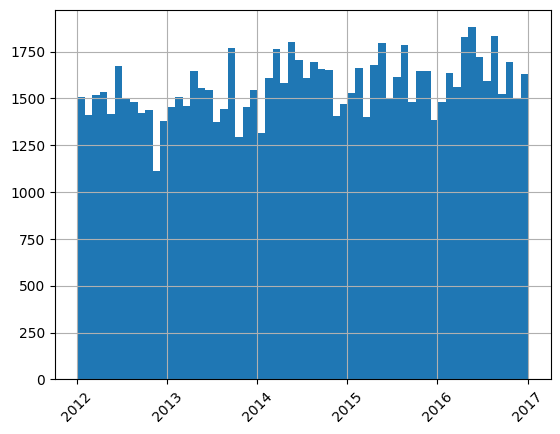

In [30]:
hy_vee_des_moines['Date'].hist(xrot=45, bins=60);

It's hard to tell whether there are any strong trends or seasonaility yet, but this isn't the best graph for that.

Nontheless, there is a slight upward trend in the data; it seems to be slowly rising throughout this timespan.

All in all, we'll need to check for this trend and seasonality before we begin modeling. Before we get ahead of ourselves, we have a little more EDA to do here at the store-level.

In [31]:
len(hy_vee_des_moines['Vendor Name'].unique())

161

In [32]:
hy_vee_des_moines['Vendor Name'].value_counts()

Vendor Name
Diageo Americas                         14878
Jim Beam Brands                         14718
Luxco-St Louis                           9228
Pernod Ricard USA/Austin Nichols         5797
Bacardi U.S.A., Inc.                     5072
                                        ...  
Aiko Importers Inc                          1
Campari                                     1
Park Street Imports-Philadelphia Dis        1
Three Rangers                               1
Tanteo Tequila                              1
Name: count, Length: 161, dtype: int64

In [50]:
hvdm_vendor_counts = hy_vee_des_moines['Vendor Name'].value_counts()
hvdm__1000_order_vendors = pd.DataFrame(hvdm_vendor_counts)
hvdm__1000_order_vendors = hvdm__100_order_vendors[hvdm__1000_order_vendors['count']>= 1000]
hvdm__1000_order_vendors

<ipython-input-50-eeec6db68470>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hvdm__1000_order_vendors = hvdm__100_order_vendors[hvdm__1000_order_vendors['count']>= 1000]


,count
Vendor Name,
Diageo Americas,14878
Jim Beam Brands,14718
Luxco-St Louis,9228
Pernod Ricard USA/Austin Nichols,5797
"Bacardi U.S.A., Inc.",5072
Phillips Beverage Company,4402
Sazerac North America,4087
Proximo,3319
"Sazerac Co., Inc.",3076


In [51]:
print("Number of Vendors with at least 1000 orders fulfilled:", len(hvdm__1000_order_vendors))
print("Fraction of rows lost if we drop vendors with fewer than 1000 orders:", 1 - sum(hvdm__1000_order_vendors['count'] / len(hy_vee_des_moines)))

Number of Vendors with at least 1000 orders fulfilled: 19
Fraction of rows lost if we drop vendors with fewer than 1000 orders: 0.142329651566085


So, if we drop the records pertaining to vendors with fewer orders, we lose 14.2% of the rows, but the vendor categories drop from an unwieldy 161 to a far more reasonable 19.

Ultimately, I'll keep the vendor column as-is, but I won't use it for modeling for now. If the overall goal is to take a model that optimizes time-series predictions on inventory and then apply it to numerous other stores, keeping it limited to the time-series data, liquor categories, and counts is a good starting place on its own.

Once this project reaches that minimum viability point, then I may be able to come back and include vendor data.

With this groundwork laid down, let's move on to modeling our time-series inventory data with a SARIMA model.

## modeling

Below, I import the packages we'll need to valuate, preprocess, and evaluate the data.

In [35]:
import numpy as np

#Scikit-Learn modules for valuation & evaluation
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

#Itertools for optimizing SARIMA hyperparameters
import itertools

#StatsModels for modeling & ACF/PACF
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

Before I do anything with the data, I should perform a valuation measure to avoid data leakage. At the end of the modeling process, I'll incorporate all three years (2012-2014) in order to forecast one year ahead. However, when training the model, I'll have to isolate the first two years (2012 & 2013) as the training set and the last year (2014) as the test set.

I'll also rename our busiest store (currently hy_vee_des_moines) to a more concise variable name.

As a side note, it seems that a lot of time-series projects will often resample to a weekly level, but [it appears that most grocers restock every day](https://www.instacart.com/company/ideas/when-do-grocery-stores-restock/#:~:text=Most%20of%20the%20larger%20grocery,store%20has%20its%20own%20schedule.), so I'll leave the granularity at the daily level for now.

In [53]:
hvdm = hy_vee_des_moines.set_index('Date')
hvdm = hvdm.sort_index()
hvdm.sample(50)

,Store Number,Category Name,Vendor Name,Bottles Sold,Sale (Dollars)
Date,,,,,
2012-08-31,2633,BLENDED AND OTHER WHISKIES,Heaven Hill Brands,12,$197.52
2012-06-14,2633,GIN,"Bacardi U.S.A., Inc.",24,$175.92
2013-12-02,2633,MISCELLANEOUS SCHNAPPS,Diageo Americas,96,$2232.00
2015-10-05,2633,LIQUEUR,Diageo Americas,5,$56.20
2013-06-06,2633,VODKA FLAVORED,Phillips Beverage Company,12,$135.00
2014-03-10,2633,IRISH WHISKIES,"Palm Bay Imports, Inc.",1,$25.01
2014-02-27,2633,VODKA FLAVORED,Phillips Beverage Company,36,$405.00
2013-04-18,2633,VODKA,Phillips Beverage Company,6,$68.40
2015-03-16,2633,VODKA,Diageo Americas,36,$945.00


Okay, looking at the 'Bottles Sold' column, I'm just now realizing that there's [some *wholesale* data in this store's records](https://bdi-wholesale.com/#:~:text=As%20a%20Hy%2DVee%20company,well%20as%20superior%20customer%20service.) alongside what seem to be *individual, in-store* sales. Nonetheless, if the primary goal of this project is to predict the inventory this store needs to restock, then this little revelation doesn't really change anything about the project, so...let's keep at it.

However, this does make it clear that the 'Bottles Sold' column is the target as it ultimately reflects the amount of inventory moved more than anything else.

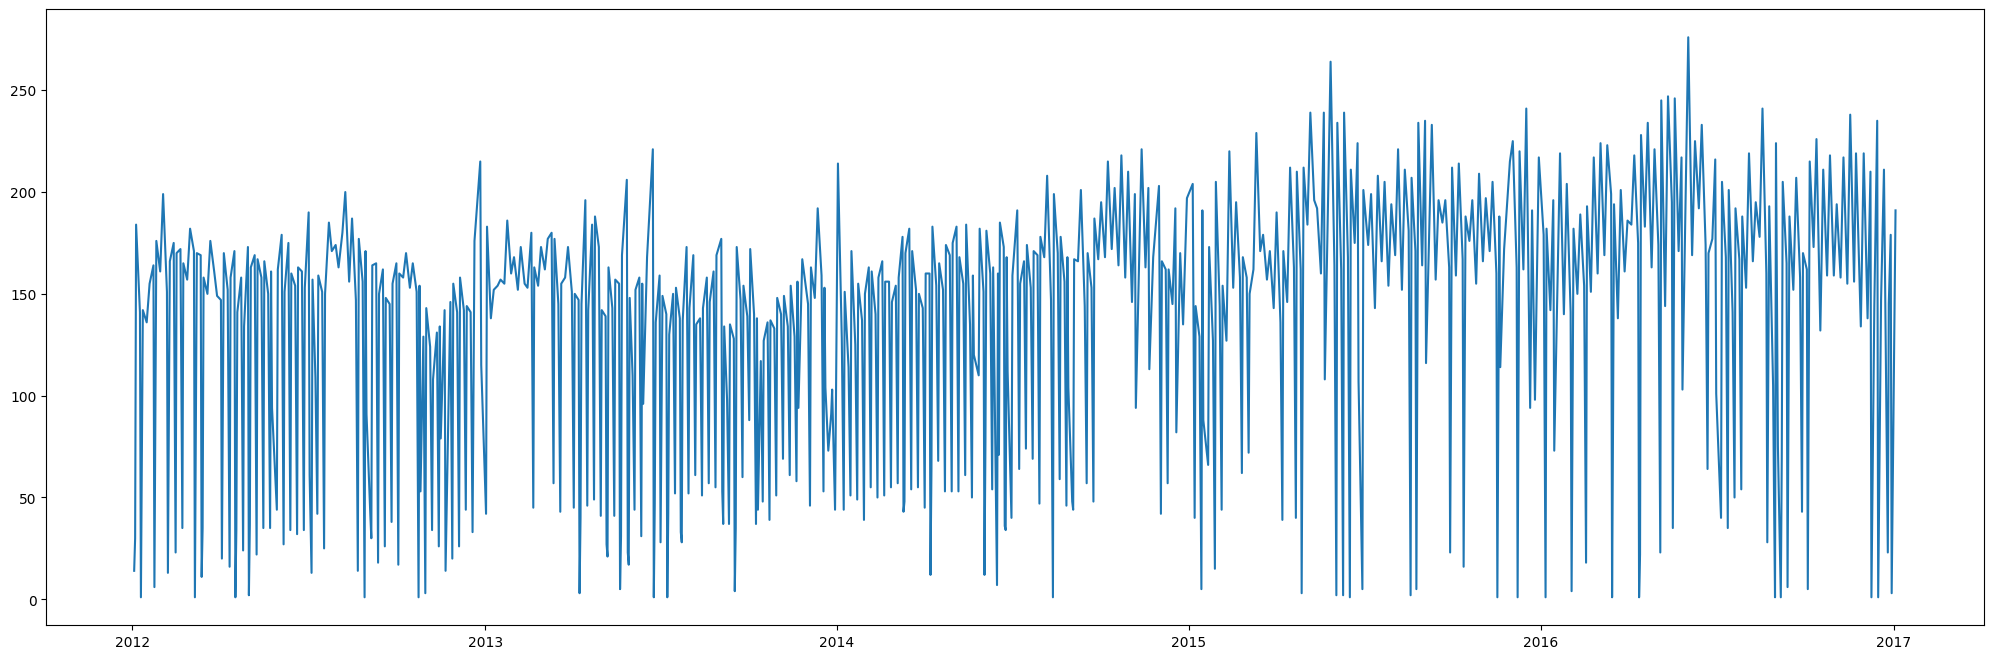

In [37]:
hvdm_bottles_sold_by_date = hvdm.groupby('Date').count()['Bottles Sold']
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(25, 8))
ax.plot(hvdm_bottles_sold_by_date.index, hvdm_bottles_sold_by_date.values);

Maybe do a square root plot, maybe don't and just tss now and then do the Dickey-Fuller test.

Definitely go back and do this for the whole trimmed_df EDA stuff, too - I remember Mark said to do a plot as opposed to a histogram for this stuff.

In [54]:
#instantiating TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5)
#establishing the target & features for modeling
X = hvdm.drop('Bottles Sold', axis=1)
y = hvdm['Bottles Sold']
#performing the split
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [55]:
#Checking to see that all X_train dates come before the X_test dates
X_train.index

DatetimeIndex(['2012-01-03', '2012-01-03', '2012-01-03', '2012-01-03',
               '2012-01-03', '2012-01-03', '2012-01-03', '2012-01-03',
               '2012-01-03', '2012-01-03',
               ...
               '2016-03-24', '2016-03-24', '2016-03-24', '2016-03-24',
               '2016-03-24', '2016-03-24', '2016-03-24', '2016-03-24',
               '2016-03-24', '2016-03-24'],
              dtype='datetime64[ns]', name='Date', length=78088, freq=None)

In [56]:
X_test.index

DatetimeIndex(['2016-03-24', '2016-03-24', '2016-03-24', '2016-03-24',
               '2016-03-24', '2016-03-24', '2016-03-24', '2016-03-24',
               '2016-03-24', '2016-03-24',
               ...
               '2017-01-03', '2017-01-03', '2017-01-03', '2017-01-03',
               '2017-01-03', '2017-01-03', '2017-01-03', '2017-01-03',
               '2017-01-03', '2017-01-03'],
              dtype='datetime64[ns]', name='Date', length=15617, freq=None)

Great, it worked. Now we'll one-hot encode the liquor categories. It's important to consider which category to drop and not just default to the first one, so let's reexamine them again to make an informed decision.

In [57]:
hvdm_category_counts = X_train['Category Name'].value_counts()
hvdm_category_counts

Category Name
LIQUEUR                       14266
VODKA                         13789
GIN                            7330
TEQUILA                        6409
VODKA FLAVORED                 6070
RUM                            5670
BOURBON                        4568
FRUIT SCHNAPPS                 3308
MISCELLANEOUS SCHNAPPS         3175
SCOTCH WHISKIES                3155
CANADIAN WHISKIES              2908
BLENDED AND OTHER WHISKIES     2869
GRAPE-BASED BRANDIES           1431
RTD COCKTAILS                   879
IRISH WHISKIES                  837
TENNESSEE WHISKIES              595
PEPPERMINT SCHNAPPS             462
OTHER FRUIT BRANDIES            367
Name: count, dtype: int64

Hold up, do I really need to drop a column? We drop them to avoid multicollinearity, but I don't think (S)ARIMA models are necessarily *linear*...or are they? Are they a kid of regression problem? Maybe I should take the median category out?

In [58]:
hvdm_category_counts.median()

3165.0

Okay, let's drop 'MISCELLANEOUS SCHNAPPS'

In [59]:
X_train_categorical_encoded = pd.get_dummies(X_train['Category Name'], dtype=int)
X_train_categorical_encoded

,BLENDED AND OTHER WHISKIES,BOURBON,CANADIAN WHISKIES,FRUIT SCHNAPPS,GIN,GRAPE-BASED BRANDIES,IRISH WHISKIES,LIQUEUR,MISCELLANEOUS SCHNAPPS,OTHER FRUIT BRANDIES,PEPPERMINT SCHNAPPS,RTD COCKTAILS,RUM,SCOTCH WHISKIES,TENNESSEE WHISKIES,TEQUILA,VODKA,VODKA FLAVORED
Date,,,,,,,,,,,,,,,,,,
2012-01-03,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2012-01-03,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2012-01-03,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2012-01-03,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2012-01-03,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-24,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-03-24,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-03-24,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [60]:
#X_train.drop('Category Name', inplace=True)
X_train_encoded = pd.concat([X_train, X_train_categorical_encoded], axis=1)
X_train_encoded.drop(['Category Name', 'MISCELLANEOUS SCHNAPPS'], axis=1, inplace=True)
X_train_encoded

,Store Number,Vendor Name,Sale (Dollars),BLENDED AND OTHER WHISKIES,BOURBON,CANADIAN WHISKIES,FRUIT SCHNAPPS,GIN,GRAPE-BASED BRANDIES,IRISH WHISKIES,LIQUEUR,OTHER FRUIT BRANDIES,PEPPERMINT SCHNAPPS,RTD COCKTAILS,RUM,SCOTCH WHISKIES,TENNESSEE WHISKIES,TEQUILA,VODKA,VODKA FLAVORED
Date,,,,,,,,,,,,,,,,,,,,
2012-01-03,2633,Diageo Americas,$295.44,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2012-01-03,2633,Diageo Americas,$274.44,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2012-01-03,2633,Pernod Ricard USA/Austin Nichols,$969.60,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2012-01-03,2633,"Moet Hennessy USA, Inc.",$459.72,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2012-01-03,2633,Jim Beam Brands,$22.04,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-24,2633,Diageo Americas,$1116.00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2016-03-24,2633,"Cedar Ridge Vineyards,LLC",$162.90,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-03-24,2633,Diageo Americas,$359.88,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [61]:
X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78088 entries, 2012-01-03 to 2016-03-24
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Store Number                78088 non-null  int64 
 1   Vendor Name                 78088 non-null  object
 2   Sale (Dollars)              78088 non-null  object
 3   BLENDED AND OTHER WHISKIES  78088 non-null  int64 
 4   BOURBON                     78088 non-null  int64 
 5   CANADIAN WHISKIES           78088 non-null  int64 
 6   FRUIT SCHNAPPS              78088 non-null  int64 
 7   GIN                         78088 non-null  int64 
 8   GRAPE-BASED BRANDIES        78088 non-null  int64 
 9   IRISH WHISKIES              78088 non-null  int64 
 10  LIQUEUR                     78088 non-null  int64 
 11  OTHER FRUIT BRANDIES        78088 non-null  int64 
 12  PEPPERMINT SCHNAPPS         78088 non-null  int64 
 13  RTD COCKTAILS               7

In [47]:
#Ran into problems with this:

#X_train_categorical = X_train['Category Name'].values
#ohe = OneHotEncoder()
#X_train_categorical_ohe = ohe.fit_transform(X_train_categorical.reshape(-1,1))
#X_train_categorical_ohe = pd.DataFrame(X_train_categorical_ohe,
#                                       columns = ohe.get_feature_names_out(),
#                                       index = X_train['Category Name'].index)
#X_train_categorical_ohe.head()

Leaving off on 6/18: Do I run the Dickey-Fuller test on this now? Of course, we'll see it's not stationary so will I stationarize it then? Next, maybe I eliminate some of these features because they don't matter, like 'store number' and 'sale price' and 'pack'? Then, can I do a naive model and then the ARIMA stuff with the ACF/PACF (。﹏。*)

In [62]:
ts = hvdm_bottles_sold_by_date
d_f_test = adfuller(ts)
d_f_test

(-6.32451285759856,
 3.00928652861843e-08,
 6,
 703,
 {'1%': -3.4396861854831964,
  '5%': -2.865660062273053,
  '10%': -2.5689640195342456},
 7593.758963534087)

These results support a claim that we can reject the null hypotheses that our training data is not stationary in terms of trends, but it can't go so far as to dimiss concerns about seasonality without examining the data more closely on the monthly, weekly, and daily levels.